#DDPM_V1

In [ ]:
%%capture
!pip install diffusers
!pip install wandb
!pip install accelerate
!pip install datasets

In [ ]:
from resnet import *
from torch.optim import lr_scheduler


In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(in_channels=1,out_channels=1 , block_out_channels=(32,64,128,128))

In [ ]:
from datasets import load_dataset

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs,)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

torch.cumprod

```
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y = torch.cumprod(x, dim=1)

tensor([[  1,   2,   6],
        [  4,  20, 120],
        [  7,  56, 504]])
```
torch.full<br>
torch.full is a function in the PyTorch library that creates a tensor of a specified shape and fills it with a specified scalar value.
```
x = torch.full((2, 3), 7)

tensor([[7, 7, 7],
        [7, 7, 7]])
```

In [ ]:
class DDPMCB(TrainCB):
  order = DeviceCB.order+1
  def __init__(self , n_steps , beta_min,beta_max):
    super().__init__()
    self.n_steps = n_steps
    self.beta_min = beta_min
    self.beta_max= beta_max

    self.beta = torch.linspace(self.beta_min,beta_max,self.n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = torch.cumprod(self.alpha,dim=0)
    self.sigma = self.beta.sqrt()

  def predict(self,learn):
    learn.preds = learn.model(*learn.batch[0]).sample
  
  def before_batch(self,learn):
    device = learn.batch[0].device
    eta = torch.randn(learn.batch[0].shape,device=device)   #noise 
    x0 = learn.batch[0]
    self.alpha_bar = self.alpha_bar.to(device)
    n = x0.shape[0]

    t = torch.randint(0 , self.n_steps , (n,) , device=device , dtype = torch.long)
    alpha_bar_t = self.alpha_bar[t].reshape(-1,1,1,1).to(device)
    xt = alpha_bar_t.sqrt()*x0 + (1 - alpha_bar_t).sqrt()*eta
    learn.batch = ((xt,t,),eta)
    # import pdb;pdb.set_trace()

  @torch.no_grad()
  def sample(self,model,sz):
    device = next(model.parameters()).device
    x_t = torch.randn(sz , device=device)
    preds=[]

    for t in reversed(range(self.n_steps)):
      t_batch = torch.full((x_t.shape[0],),t,device=device,dtype=torch.long)
      z = (torch.randn(x_t.shape) if t>0  else torch.zeros(x_t.shape)).to(device)
      alpha_bar_t1 = self.alpha_bar[t-1] if t > 0 else torch.tensor(1)

      beta_bar_t = 1 - self.alpha_bar[t]
      beta_bar_t1 = 1 - alpha_bar_t1
      noise_pred = learn.model(x_t,t_batch).sample
      x_0_hat = ((x_t - beta_bar_t.sqrt() * noise_pred) / self.alpha_bar[t].sqrt() ).clamp(-1,1)
      x0_coeff = alpha_bar_t1.sqrt() * (1 - self.alpha[t]) / beta_bar_t
      xt_coeff = self.alpha[t].sqrt()*beta_bar_t1 / beta_bar_t
      x_t = x_0_hat*x0_coeff + x_t * xt_coeff + self.sigma[t] * z
      preds.append(x_t.cpu())
      # import pdb;pdb.set_trace()
    return preds

In [ ]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dt)

set_seed(42)
sched = partial(lr_scheduler.OneCycleLR , max_lr = lr , total_steps = tmax)
ddpm_cb = DDPMCB(n_steps = 1000 , beta_min = .001 , beta_max = .02)
metrics = MetricsCB()
astats = ActivationStats(fc.risinstance(GeneralRelu))

cbs = [DeviceCB(), metrics, astats ,ProgressCB(plot=True), ddpm_cb,BatchSchedCB(sched)]
learn = Learner(model,dls,nn.MSELoss() , lr=lr , cbs = cbs , opt_func = optim.AdamW)

loss,epoch,train
0.047,0,train
0.019,0,eval
0.016,1,train
0.014,1,eval
0.013,2,train
0.013,2,eval
0.012,3,train
0.011,3,eval
0.011,4,train
0.011,4,eval


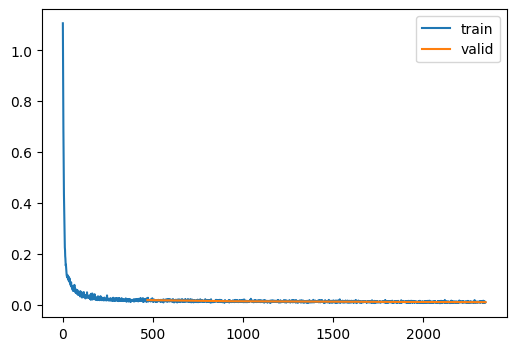

In [ ]:
learn.fit(5)

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok = True)

torch.save(learn.model , mdl_path/'fashion_ddpm.pkl')
learn.model = torch.load(mdl_path/"fashion_ddpm.pkl")

In [ ]:
set_seed(42)
samples = ddpm_cb.sample(learn.model , (16,1,32,32))

In [ ]:
%matplotlib auto
from fastcore.foundation import L

import matplotlib.animation as animation
from IPython.display import display , HTML

fig,ax = plt.subplots(figsize = (3,3))
def show_i(i):
  return show_image(samples[i][9] , ax=ax,animated=True).get_images()

r = L.range(800,990,5) + L.range(990,1000) + [999]*10
ims = r.map(show_i)

animate = animation.ArtistAnimation(fig,ims,interval=50,blit=True,repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: <object object at 0x7f9dddb9f460>


#DDPM_V2

In [ ]:

xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [ ]:
%matplotlib inline

plt.plot(beta , label = 'beta')
plt.plot(sigma , label = 'sigma')
plt.plot(alpha_bar , label = 'alpha_bar')
plt.legend()

In [ ]:
def noisify(x0 , alpha_bar):
  device = x0.device
  n = len(x0)
  t = torch.randint(0 , n_steps , (n,) , dtype = torch.long)
  eta = torch.randn(x0.shape , device = device)
  alpha_bar_t = alpha_bar[t].reshape(-1,1,1,1).to(device)
  xt = alpha_bar_t.sqrt() * x0 + (1 -alpha_bar_t).sqrt()*eta
  return (xt,t.to(device)),eta

In [ ]:

dt = dls.train
xb,yb = next(iter(dt))

(xt,t) , eta = noisify(xb[:16] , alpha_bar)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│ in noisify:2                                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'tuple' object has no attribute 'device'

In [ ]:
from diffusers import UNet2DModel

In [ ]:
torch.no_grad()
def _sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz , device=device)
    preds=[]

    for t in reversed(range(n_steps)):
      t_batch = torch.full((x_t.shape[0],),t,device=device,dtype=torch.long)
      z = (torch.randn(x_t.shape) if t>0  else torch.zeros(x_t.shape)).to(device)
      alpha_bar_t1 = alpha_bar[t-1] if t > 0 else torch.tensor(1)

      beta_bar_t = 1 - alpha_bar[t]
      beta_bar_t1 = 1 - alpha_bar_t1
      noise_pred = learn.model((x_t,t_batch))
      x_0_hat = ((x_t - beta_bar_t.sqrt() * noise_pred) / alpha_bar[t].sqrt() ).clamp(-1,1)
      x0_coeff = alpha_bar_t1.sqrt() * (1 - alpha[t]) / beta_bar_t
      xt_coeff = alpha[t].sqrt()*beta_bar_t1 / beta_bar_t
      x_t = x_0_hat*x0_coeff + x_t * xt_coeff + sigma[t] * z
      preds.append(x_t.cpu())
    return preds

In [ ]:
class DDPMCB(Callback):
  order = DeviceCB.order +1 
  def __init__(self , n_steps , beta_min,beta_max):
    super().__init__()
    self.n_steps = n_steps
    self.beta_min = beta_min
    self.beta_max= beta_max

    self.beta = torch.linspace(self.beta_min,beta_max,self.n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = torch.cumprod(self.alpha,dim=0)
    self.sigma = self.beta.sqrt()
  
  def before_batch(self,learn):
    learn.batch = noisify(learn.batch[0] , self.alpha_bar)

  def sample(self,model,sz):
    return _sample(model,sz, self.alpha,self.alpha_bar , self.sigma , self.n_steps)

In [ ]:
class UNet(UNet2DModel):
  def forward(self,x):
    return super().forward(*x).sample

In [ ]:
ddpm_cb = DDPMCB(n_steps = 1000 , beta_min = .0001 , beta_max = .02)
model = UNet(in_channels=1,out_channels=1 , block_out_channels=(32,64,128,128))


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


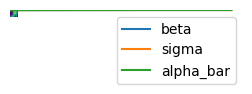

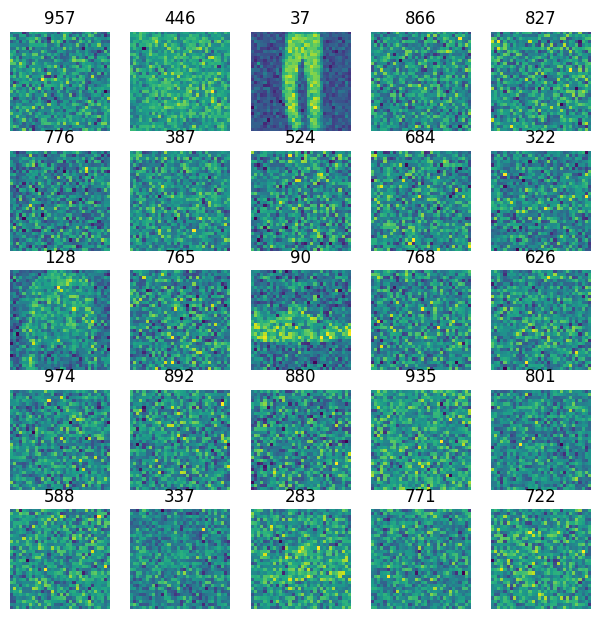

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [ ]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): torch.nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
init_ddpm(model)

In [ ]:
opt_func = partial(optim.AdamW , eps = 1e-5)

In [ ]:

learn = TrainLearner(model,dls,nn.MSELoss() , lr=lr , cbs = cbs , opt_func = opt_func)

loss,epoch,train
0.147,0,train
0.025,0,eval


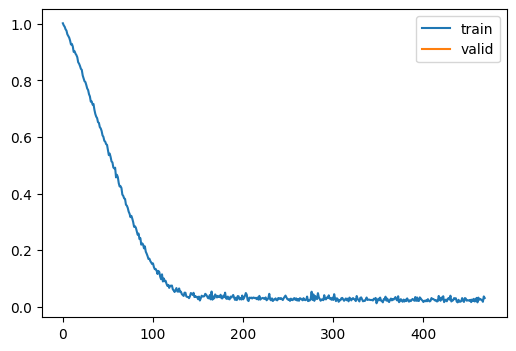

In [ ]:
learn.fit(1)

In [ ]:
set_seed(42)
samples = ddpm_cb.sample(learn.model , (1,1,32,32))

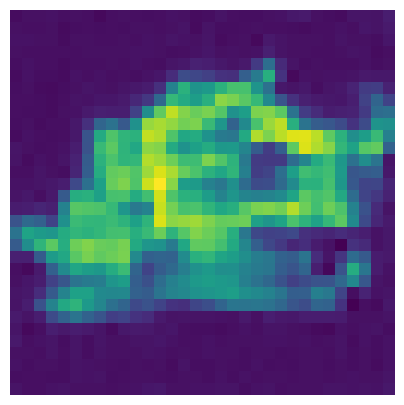

In [ ]:
show_images(samples[-1] , figsize=(5,5))

#DDPM_V3

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
import logging
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
     

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from types import SimpleNamespace

def linear_sched(beta_min = .0001 , beta_max = .02 , n_steps = 1000):
  beta = torch.linspace(beta_min ,beta_max , n_steps)
  return SimpleNamespace(a=1. -beta ,abar = (1. -beta).cumprod(dim=0) , sig = beta.sqrt())

In [ ]:
def abar(t,T):
  return (t/T*math.pi/2).cos()**2

In [ ]:
def cos_sched(n_steps=1000):
  ts = torch.linspace(0,n_steps-1 , n_steps)
  ab =abar(ts,n_steps)
  alp = ab/abar(ts-1,n_steps)
  return SimpleNamespace(a = alp , abar=ab,sig = (1-alp).sqrt())

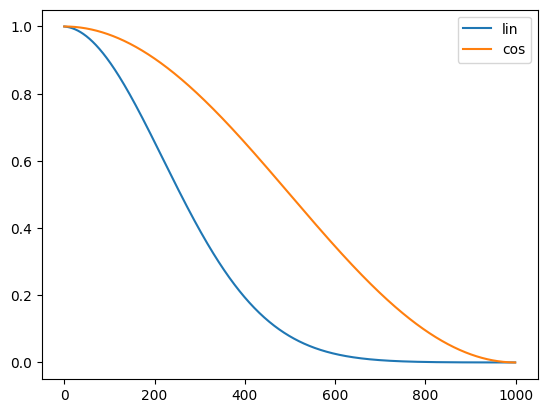

In [ ]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

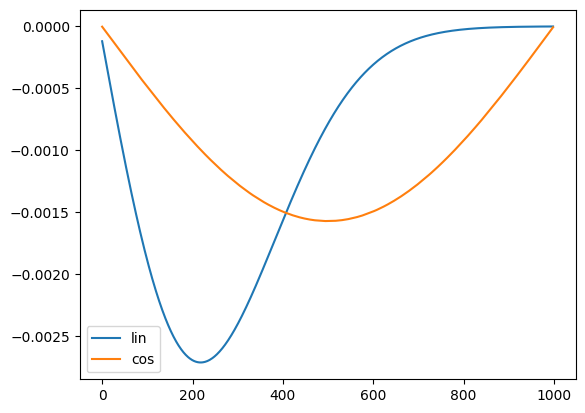

In [ ]:
#these are the slope of above curve repersent how much change we have to do


plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

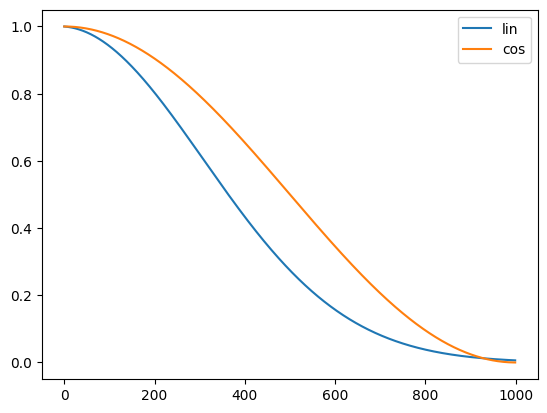

In [ ]:
#so if we do beta_max =.01 then both curve looks almost similar
lin_abar = linear_sched(beta_max=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

In [ ]:
n_steps = 1000
lin_abar = linear_sched(beta_max=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [ ]:
def noisify(x0 , alpha_bar):
  device = x0.device
  n = len(x0)
  t = torch.randint(0 , n_steps , (n,) , dtype = torch.long)
  eta = torch.randn(x0.shape , device = device)
  alpha_bar_t = alpha_bar[t].reshape(-1,1,1,1).to(device)
  xt = alpha_bar_t.sqrt() * x0 + (1 -alpha_bar_t).sqrt()*eta
  return (xt,t.to(device)),eta

In [ ]:
dt = dls.train
xb,yb = next(iter(dt))

In [ ]:

(xt,t),eta = noisify(xb[:25],alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

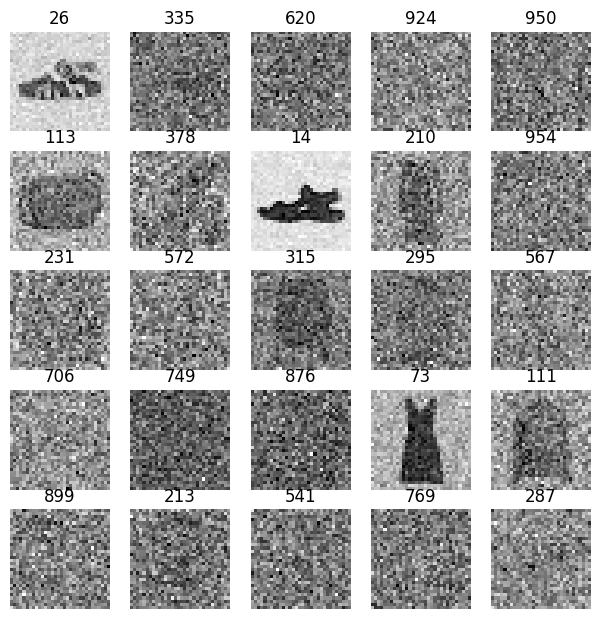

In [ ]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

In [ ]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torch.nn import init

lr = 1e-2
epochs = 3
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ TrainCB() , DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.742,0,train
1.000,0,eval
0.999,1,train
0.998,1,eval
0.997,2,train
0.997,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


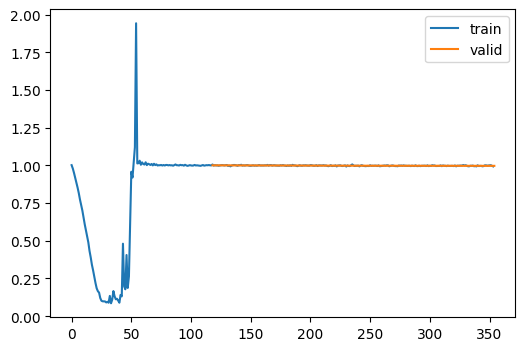

In [ ]:
learn.fit(3)


In [ ]:

@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        alpha_bar_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        beta_bar_t = 1-alphabar[t]
        beta_bar_t1 = 1-alpha_bar_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - beta_bar_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * alpha_bar_t1.sqrt()*(1-alpha[t])/beta_bar_t + x_t * alpha[t].sqrt()*beta_bar_t1/beta_bar_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
n_samples = 64

samples = sample(model, (n_samples, 1, 32, 32))

In [ ]:
samples[:16][0].shape

torch.Size([64, 1, 32, 32])

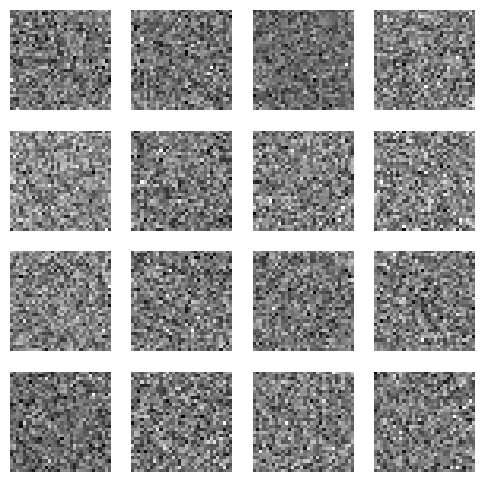

In [ ]:
show_images(samples[0][:16], imsize=1.5)



##skip_sampling

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        alpha_bar_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        beta_bar_t = 1-alphabar[t]
        beta_bar_t1 = 1-alpha_bar_t1
        if t% 3 ==0 or t< 50 :
          noise = model((x_t, t_batch))
        x_0_hat = ((x_t - beta_bar_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * alpha_bar_t1.sqrt()*(1-alpha[t])/beta_bar_t + x_t * alpha[t].sqrt()*beta_bar_t1/beta_bar_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample(model, (n_samples, 1, 32, 32)) 


CPU times: user 17.8 s, sys: 136 ms, total: 18 s
Wall time: 18.1 s


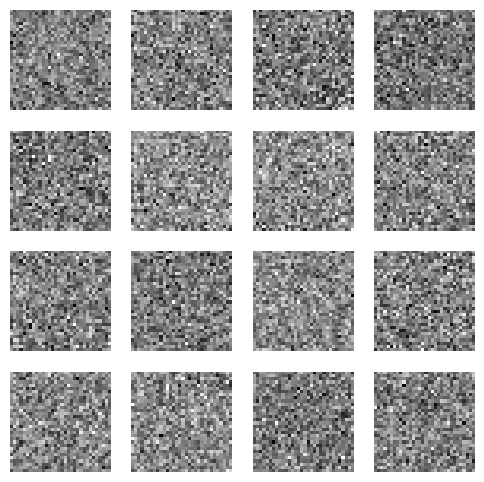

In [ ]:
show_images(samples[0][:16], imsize=1.5)


In [ ]:
sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        alpha_bar_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        beta_bar_t = 1-alphabar[t]
        beta_bar_t1 = 1-alpha_bar_t1
        if t in sample_at:
          noise = model((x_t, t_batch))
        x_0_hat = ((x_t - beta_bar_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * alpha_bar_t1.sqrt()*(1-alpha[t])/beta_bar_t + x_t * alpha[t].sqrt()*beta_bar_t1/beta_bar_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds